In [71]:
# set the matplotlib backend so figures can be saved in the background
%matplotlib inline
import matplotlib
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform
from skimage import exposure
from skimage import io
import argparse
import random
import os

In [31]:
!pip install scikit-image

     |████████████████████████████████| 26.5 MB 381 kB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 2.8 MB/s eta 0:00:01


In [84]:
def load_split(basePath, csvPath):
	# initialize the list of data and labels
	data = []
	labels = []
	# load the contents of the CSV file, remove the first line (since
	# it contains the CSV header), and shuffle the rows (otherwise
	# all examples of a particular class will be in sequential order)
	rows = open(csvPath).read().strip().split("\n")[1:]
	random.shuffle(rows)
    	# loop over the rows of the CSV file
	for (i, row) in enumerate(rows):
		# check to see if we should show a status update
		if i > 0 and i % 1000 == 0:
			print("[INFO] processed {} total images".format(i))
		# split the row into components and then grab the class ID
		# and image path
		(label, imagePath) = row.strip().split(",")[-2:]
		# derive the full path to the image file and load it
		imagePath = os.path.sep.join([basePath, imagePath])
		image = io.imread(imagePath)
        # resize the image to be 32x32 pixels, ignoring aspect ratio,
		# and then perform Contrast Limited Adaptive Histogram
		# Equalization (CLAHE)
		image = transform.resize(image, (32, 32))
		image = exposure.equalize_adapthist(image, clip_limit=0.1)
		# update the list of data and labels, respectively
		data.append(image)
		labels.append(int(label))
	# convert the data and labels to NumPy arrays
	data = np.array(data)
	labels = np.array(labels)
	# return a tuple of the data and labels
	return (data, labels)

In [85]:
args = {}
args["dataset"] = 'dataset/'

In [86]:
# derive the path to the training and testing CSV files
trainPath = os.path.sep.join([args["dataset"], "Train.csv"])
testPath = os.path.sep.join([args["dataset"], "Test.csv"])
# load the training and testing data
print("[INFO] loading training and testing data...")
(trainX, trainY) = load_split(args["dataset"], trainPath)
(testX, testY) = load_split(args["dataset"], testPath)

[INFO] loading training and testing data...
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images
[INFO] processed 13000 total images
[INFO] processed 14000 total images
[INFO] processed 15000 total images
[INFO] processed 16000 total images
[INFO] processed 17000 total images
[INFO] processed 18000 total images
[INFO] processed 19000 total images
[INFO] processed 20000 total images
[INFO] processed 21000 total images
[INFO] processed 22000 total images
[INFO] processed 23000 total images
[INFO] processed 24000 total images
[INFO] processed 25000 total images
[INFO] processed 26000 total images
[INFO] processed 27000 total 

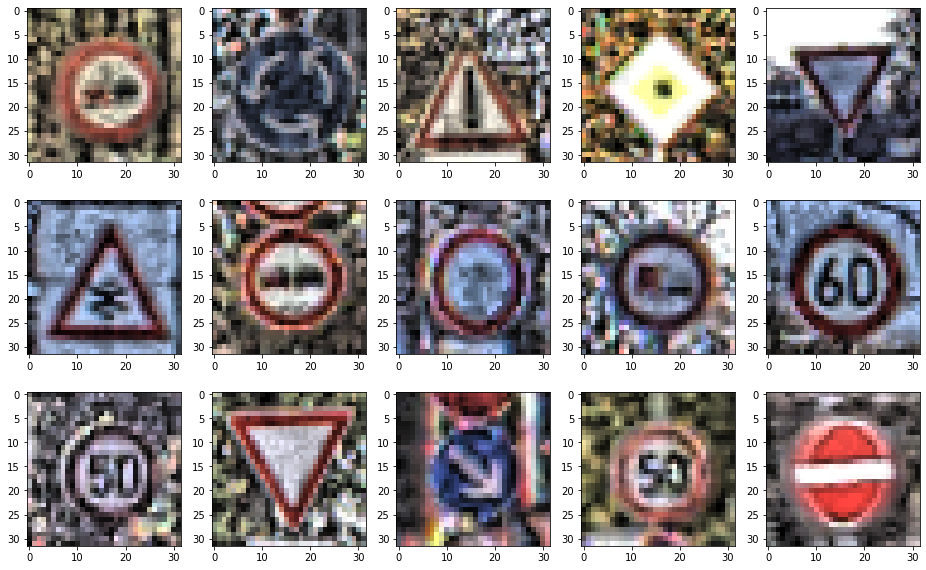

In [87]:
fig, axes = plt.subplots(3,5, figsize=(16,10))

for i in range(3):
    for j in range(5):
        axes[i, j].imshow(trainX[np.random.randint(39000, size=1)[0]][:,:,:])

In [88]:
xtrain = np.copy(trainX)
xtest = np.copy(testX)
ytrain = np.copy(trainY)
ytest = np.copy(testY)

In [89]:
# scale data to the range of [0, 1]
trainX = trainX.astype("float32") 
testX = testX.astype("float32")
# one-hot encode
numLabels = len(np.unique(trainY))
trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)
# account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [95]:
numLabels

43

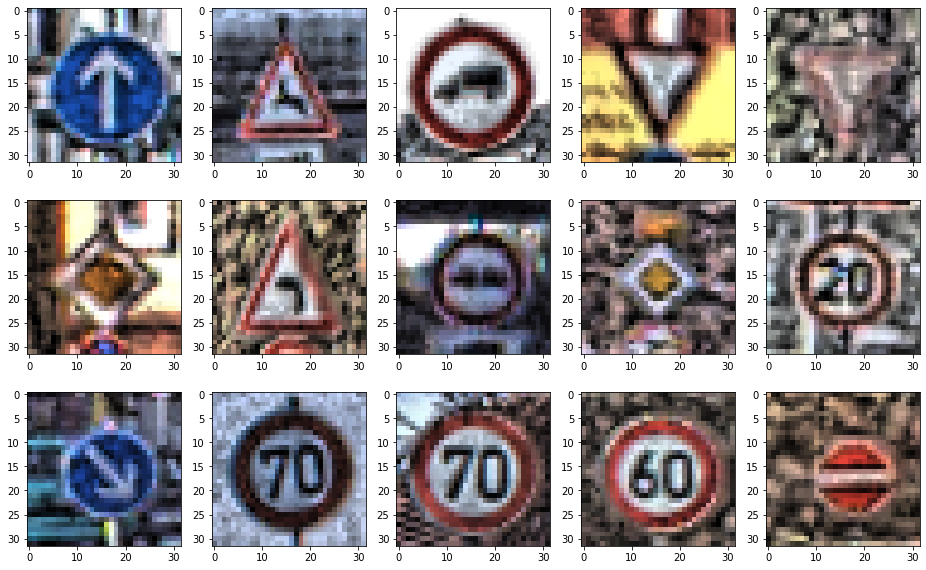

In [96]:
fig, axes = plt.subplots(3,5, figsize=(16,10))

for i in range(3):
    for j in range(5):
        axes[i, j].imshow(trainX[np.random.randint(39000, size=1)[0]][:,:,:])

In [91]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from art.attacks import FastGradientMethod, ProjectedGradientDescent, PixelAttack
from art.classifiers import KerasClassifier

Using TensorFlow backend.


In [92]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


In [93]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr



In [100]:
def resnet_v2(input_shape, depth, num_classes=43):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    #if (depth - 2) % 9 != 0:
    #    raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [101]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 10
data_augmentation = True
num_classes = 43

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

#n = 5

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
#if version == 1:
#    depth = n * 6 + 2
#elif version == 2:
#    depth = n * 9 + 2

depth = 18

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

input_shape = trainX.shape[1:]

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(trainX, axis=0)
    trainX -= x_train_mean
    testX -= x_train_mean

print('x_train shape:', trainX.shape)
print(trainX.shape[0], 'train samples')
print(testX.shape[0], 'test samples')
print('y_train shape:', trainY.shape)

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(trainX)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX, testY),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

x_train shape: (39209, 32, 32, 3)
39209 train samples
12630 test samples
y_train shape: (39209, 43)
Learning rate:  0.001
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 32, 32, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 32, 32, 16)   64          conv2d_40[0][0]                  
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 32, 32, 16)   0           batc

Epoch 1/10
Learning rate:  0.001
1226/1226 [==============================] - 33s 27ms/step - loss: 2.0189 - accuracy: 0.4659 - val_loss: 1.6200 - val_accuracy: 0.5484
Epoch 2/10
Learning rate:  0.001
  11/1226 [..............................] - ETA: 20s - loss: 1.2482 - accuracy: 0.6562

/home/rishi/anaconda3/envs/tensorflow1.1/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


1226/1226 [==============================] - 21s 17ms/step - loss: 0.9059 - accuracy: 0.7832 - val_loss: 1.1990 - val_accuracy: 0.6992
Epoch 3/10
Learning rate:  0.001
1226/1226 [==============================] - 22s 18ms/step - loss: 0.5793 - accuracy: 0.8826 - val_loss: 1.0802 - val_accuracy: 0.7356
Epoch 4/10
Learning rate:  0.001
1226/1226 [==============================] - 22s 18ms/step - loss: 0.4565 - accuracy: 0.9171 - val_loss: 0.7961 - val_accuracy: 0.8084
Epoch 5/10
Learning rate:  0.001
1226/1226 [==============================] - 22s 18ms/step - loss: 0.3969 - accuracy: 0.9346 - val_loss: 0.8629 - val_accuracy: 0.8037
Epoch 6/10
Learning rate:  0.001
1226/1226 [==============================] - 22s 18ms/step - loss: 0.3560 - accuracy: 0.9447 - val_loss: 0.8879 - val_accuracy: 0.7970
Epoch 7/10
Learning rate:  0.001
1226/1226 [==============================] - 22s 18ms/step - loss: 0.3321 - accuracy: 0.9525 - val_loss: 1.0917 - val_accuracy: 0.7727
Epoch 8/10
Learning rate:

In [102]:
# Score trained model.
scores = model.evaluate(testX, testY, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

12630/12630 [==============================] - 3s 208us/step
Test loss: 0.8008687707987081
Test accuracy: 0.8441013693809509


In [103]:
model.save('gtsrb-resnet18.h5')

In [104]:
classifier = KerasClassifier(model=model, clip_values=None, use_logits=False)

In [108]:
import time
start = time.process_time()
model.predict(testX)
print("Time taken for single prediction: {}".format((time.process_time() - start)/12630))

Time taken for single prediction: 0.00017686206817101984


In [116]:
fgsm = FastGradientMethod(classifier, eps=0.05)
x_test_adv = fgsm.generate(x=testX)

start = time.process_time()
predictions = classifier.predict(x_test_adv)
print("Time taken for single prediction: {}".format((time.process_time() - start)/12630))

accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(testY, axis=1)) / len(testY)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Time taken for single prediction: 0.00021598797513858108
Accuracy on adversarial test examples: 7.37925574030087%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

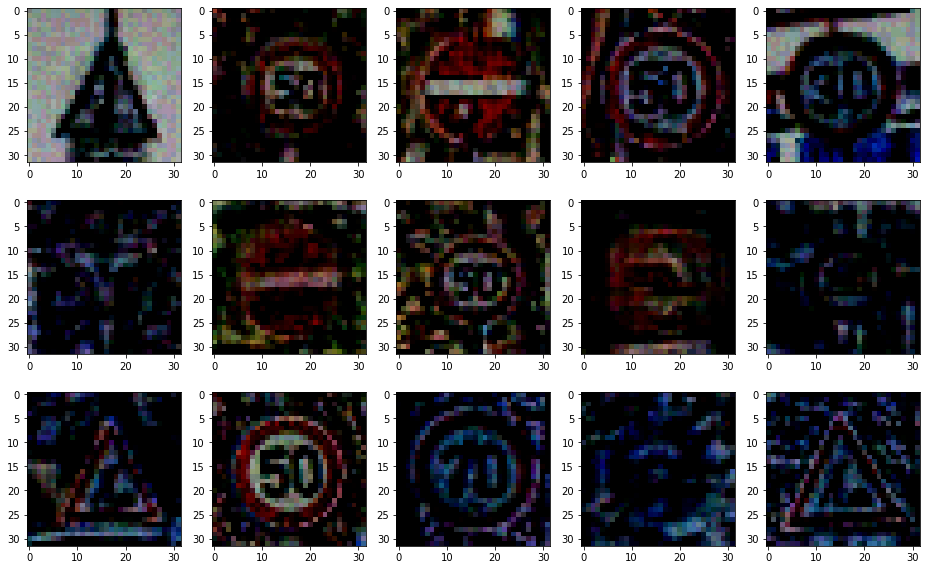

In [117]:
fig, axes = plt.subplots(3,5, figsize=(16,10))

for i in range(3):
    for j in range(5):
        axes[i, j].imshow(x_test_adv[np.random.randint(10000, size=1)[0]][:,:,:])